# What makes art, art? (Models of Mind and Brain, Final Project)
### Hannah Paris Cowley

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im
from PIL import Image
import random
import os
import math

## Introduction:

### Question: What _really_ goes into the works of famous artists? 
When looking at a piece of art, it's hard to put a finger on what about the piece we find enjoyable, moving, or disturbing. When analyzing the work of artists, there's more that goes into their work than analyses of brushstroke patterns and color palettes. Using generative models, I've decided to look into the key features of the artwork of famous artists, hoping to uncover how our minds might generalize the works of Monet. This will help answer a rather complicated question, among other things: If I go to a museum and tell you that I saw a great Monet painting today, what mental image do you get?

### DCGAN: Deep Convolutional Generative Adversarial Network
I chose to use a generative model to distill the key features of artwork. By using an generative model, I am able to look at "artwork" the computer generates, to assess how the network has generalized features of the training artwork. 

A DCGAN is a generative model that uses unsupervised learning in training. Its specific architecture has made it relatively successful in learning from unlabeled data (Radford, Metz, & Chintala, 2015). The network consists of multiple convolutional layers and relies on the generative adversarial network (GAN) approach for training the network. 
![DCGAN diagram](./DCGAN.png)
(_DCGAN diagram courtesy of https://github.com/carpedm20/DCGAN-tensorflow_)


Because the images generated by the model have no explicit target other than wanting them to look "Monet-ish", one might think it would be impossible to properly train! However, GAN has some tricks that make it possible. 

Alongside the generative network that is producing images, a discriminator network is being trained. This discriminator network is taking in the output images from the generator and asking "Was this image generated or is it a training image?" Then, the error from this _discriminator_ network is backpropogated both through the discriminator network _and_ the generator network, with the goal of making the discriminator network more likely to confuse training and generated images on the next epoch (https://blog.openai.com/generative-models/). If the discriminator network can be "tricked" into thinking that a generated image is actually a training image, then we know our generative model is doing well at mimicking the training data. 

Essentially, we want our real Monet images to become indistinguishable from our generated Monet images. Of course, in practice this won't happen. But at the core, our DCGAN will (hopefully) be generalizing from the training data what makes the data the way it is, which will in turn help us answer what makes a work of Monet, Monet!

I specifically chose a DCGAN for a few reasons. First, it's relatively easy to train. There are no labels required, and I can run 300 epochs of training on my personal laptop in just under 2 hours. Second, I found an existing implemenation of DCGAN on GitHub, using TensorFlow: https://github.com/carpedm20/DCGAN-tensorflow. Because the discriminator network is built into the model, I also don't have to train any other networks to do some basic analyses on how the DCGAN is performing in generating images. I can simply look at the loss of the discriminator network to see how closely the generated images match the training images, as a function of number of epochs.

### What you'll see here
**First, preliminary investigations:**
* Given lower-dimensional training data, how does our DCGAN behave?
    * This is investigated through using black and white random checkerboards as input. It is our proof of concept that the DCGAN can, indeed, generalize features of images (even when the training images have some noise).
* Given a small sample across many varieties of Monet paintings, how does our DCGAN behave?
    * This is my first-pass try at making the DCGAN generate "real" Monets. As you'll see below, the training data had critical flaws that made me follow up on this preliminary investigation with a revised training set.

**Next, the main investigation:**
* Given a set of Monets of similar style and subject matter, how does our DCGAN behave?
    * The training set is revised from our preliminary Monet investigation, and we'll see that while the DCGAN does better than it did with the original training set, our outputs don't look strictly like Monets.
    
**Third, some follow up investigations:**
* Given black and white Monet paintings, how does our DCGAN perform?
    * Eliminating color makes our Monet works slightly lower dimensional, as the network doesn't have to learn the color palette used by Monet. We'll see that this gives similar results to the main investigation.
* Given a distorted spatial structure of Monet paintings, how does our DCGAN perform?
    * Using a non-random scrambling script, all colorized Monet training images were scrambled. We'll see that this yields better results than our main investigation.

**Finally, I'll draw some conclusions and make some suggestions for further improvement and investigation.**


**A word to the wise**: Jupyter notebooks aren't the best platform to use for running the training or test scripts, as the implementation I used here runs from the command line. I've included code snippets for running the training if you wish, but you should be advised to proceed with caution...
1. Training takes a _very_ long time
2. Training takes a _lot_ of RAM and harddrive space
3. Training will _overwrite_ existing models.

## Preliminary Investigation: Checkerboards

To learn about how generative models work, I'll first train my DCGAN on simple configurations of a checkerboard-like pattern, and see if it produces a checkerboard in response. To evaluate how well the network is doing, at the end we'll look at the loss of the discriminator and generative network over time. This will give us clues about how error-prone our model is.

### Training data creation:
Using numpy (found in the cells below), I created 500 different checkerboard configurations to feed into the DCGAN.

In [ ]:
# width and height of board = 250 (to match cropping of real images)
def build_checkerboard(c_size, c_num):
    board = np.zeros((250, 250))
    for i in range(c_num):
        top_left_0 = random.randint(0, 249)
        top_left_1 = random.randint(0, 249)
        for i in range(c_size):
            if top_left_0 + i < 249:
                board[top_left_0 + i][top_left_1] = 1
                for j in range(c_size):
                    if top_left_1 + j < 249:
                        board[top_left_0 + i][top_left_1 + j] = 1
    return board

In [ ]:
# creating the checkerboards and saving within the data directory

if not os.path.exists("./data/checkerboards"):
    os.mkdir("./data/checkerboards")
  
os.chdir("./data/checkerboards")

for size in [2, 5, 10, 15]:
    for num in [100, 200, 300, 400, 500]:
        for i in range(5):
            name = 's{}n{}iter{}.jpg'.format(size, num, i)
            b = build_checkerboard(size, num)
            im.imsave(name, b, cmap=plt.cm.gray)

os.chdir("../..")

Selected training data examples:
![Sparse](data/checkerboards/s2n100iter0.jpg)
![Medium](data/checkerboards/s5n400iter0.jpg)
![Large](data/checkerboards/s15n200iter0.jpg)
![Extra Large](data/checkerboards/s15n500iter3.jpg)

A model was trained using this cropped dataset using the bash command below. **Please note, if you run this, you will over-write existing models. _Only run if you're absolutely sure!_**

In [ ]:
%%bash
python3 main.py --dataset=checkerboards --input_height=250 --input_width=250 --train_size=101 --epoch=300 --crop --train

### Checkerboards Results:

While training, my model produced output images at every third epoch. These test images are displayed in an 8x8 grid, so one image reproduced below is _actually_ 64 different images (all smooshed into one jpg for convenience). The model was trained

**Epoch 2**
![Cropped Epoch 2](./samples/checkerboards/train_02_0000.png)
**Epoch 61**
![Cropped Epoch 62](./samples/checkerboards/train_62_0000.png)
**Epoch 151**
![Cropped Epoch 152](./samples/checkerboards/train_152_0000.png)
**Epoch 205**
![Cropped Epoch 206](./samples/checkerboards/train_206_0000.png)
**Epoch 241**
![Cropped Epoch 242](./samples/checkerboards/train_242_0000.png)
**Epoch 298**
![Cropped Epoch 299](./samples/checkerboards/train_299_0000.png)

### Checkerboards Discussion:
The training data did not have a regular structure. The size of squares varied, as well as the density of white squares on the black background. Nonetheless, the DCGAN seemed to be able to make some sort of generalization of sorts. Upon visual inspection, we see that the last shown epoch (epoch 298) has a fairly regular checkerboard-like pattern in each of the images of the grid. Some are darker and some are lighter, no doubt due to checkerboard density differences in the dataset, but it's pretty neat how the model generalized the checkerboard pattern!

Below, I'll quantify the performance on this dataset by looking at discriminator loss over training time. Performance indicative of the model entering a stable state, a state in which the training data and generated data has become highly confusable, would indicate that the DCGAN is generating images that it deems to match the training data.

In [69]:
with open("Checkerboards_loss.txt", "rt") as f:
    epoch = 0
    check_d_loss = []
    check_g_loss = []
    all_epoch = []
    for line in f:
        if line.startswith("[Sample]"):
            continue
        line = line.split(',')
        d_loss_txt = line[1]
        d_loss = d_loss_txt.split()[1]
        check_d_loss.append(float(d_loss))
        g_loss_txt = line[2]
        g_loss = g_loss_txt.split()[1]
        check_g_loss.append(float(g_loss))
        all_epoch.append(epoch)
        epoch += 1

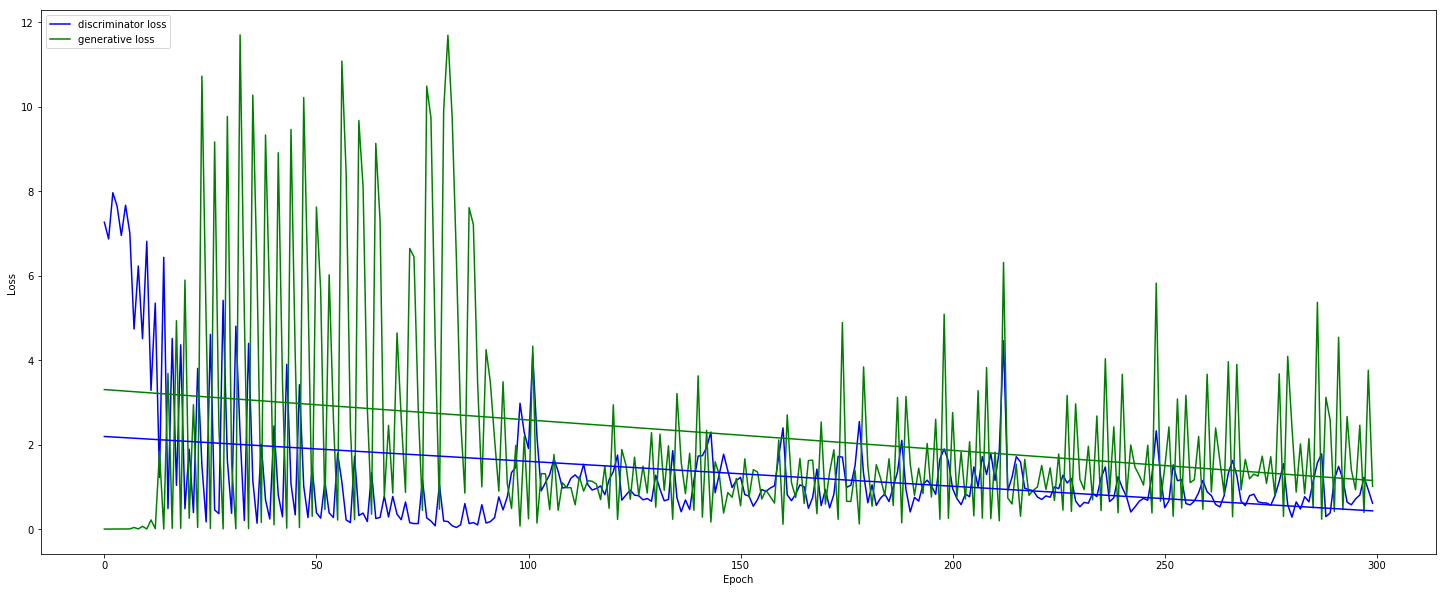

In [72]:
plt.figure(num=1, figsize=(25,10))
plt.plot(all_epoch, check_d_loss, c='blue')
plt.plot(all_epoch, check_g_loss, c='green')
bf_check_g = np.poly1d(np.polyfit(all_epoch, check_g_loss, 1))(all_epoch)
bf_check_d = np.poly1d(np.polyfit(all_epoch, check_d_loss, 1))(all_epoch)
plt.plot(all_epoch, bf_check_g, c="green")
plt.plot(all_epoch, bf_check_d, c="blue")
plt.legend(['discriminator loss', 'generative loss'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Here we see that around 100 epochs, both of the networks start to minimize their loss. However, even small spikes in the discriminator network loss correspond to ratherlarge spikes in the generative network loss. This may indicate that the model really isn't terribly stable. However, the fact that it gets considerably better over time is promising, and is a proof of concept that the model is at least able to do what we ask of it with a low-dimensional training set.

## Preliminary Investigation: Real Paintings

### Training data collection:
Data was obtained from Google Image search and https://www.wikiart.org/. All images were hand re-sized and cropped centrally. Please note, the data sets for this project are relatively small. Painters only painted so much!

I collected images of Monet's works in 4 categories, 25 images per category: people, flowers, landscapes, and seascapes. This data can be found in ./data/monet_cropped. The data chosen here was intentionally over-diverse and investigational. I wasn't sure exactly what I'd get, so I started broad!

2 works from each category are reproduced below:

![Woman Reading](data/monet_cropped/a-woman-reading.jpg)
![Parasol Woman](data/monet_cropped/the-promenade-woman-with-a-parasol.jpg)

![Poppies](data/monet_cropped/poppies-at-giverny.jpg)
![Pine Trees](data/monet_cropped/under-the-pine-trees-at-the-end-of-the-day.jpg)

![Flowers & Fruit](data/monet_cropped/flowers-and-fruit.jpg)
![Chrysanthems](data/monet_cropped/two-vases-with-chrysanthems.jpg)

![Green Wave](data/monet_cropped/the-green-wave.jpg)
![Night Seascape](data/monet_cropped/seascape-night-effect.jpg)

A model was trained using this cropped dataset using the bash command below. **Please note, if you run this, you will over-write existing models. Only run if you're _absolutely sure_!**

In [ ]:
%%bash
python3 main.py --dataset=monet_cropped --input_height=250 --input_width=250 --train_size=97 --epoch=300 --crop --train

## Preliminary Monet Results:
While training, my model produced test images at each epoch. These test images are displayed in an 8x8 grid, so one image reproduced below is _actually_ 64 different images (all smooshed into one jpg for convenience).

**Epoch 1**
![Cropped Epoch 1](./samples/monet_cropped/train_01_0000.png)
**Epoch 61**
![Cropped Epoch 31](./samples/monet_cropped/train_61_0000.png)
**Epoch 151**
![Cropped Epoch 31](./samples/monet_cropped/train_151_0000.png)
**Epoch 205**
![Cropped Epoch 205](./samples/monet_cropped/train_205_0000.png)
**Epoch 241**
![Cropped Epoch 31](./samples/monet_cropped/train_241_0000.png)
**Epoch 298**
![Cropped Epoch 31](./samples/monet_cropped/train_298_0000.png)

In [106]:
with open("Cropped_loss.txt", "rt") as f:
    epoch = 0
    cropped_d_loss = []
    cropped_g_loss = []
    all_epoch = []
    for line in f:
        if line.startswith("[Sample]"):
            continue
        line = line.split(',')
        d_loss_txt = line[1]
        d_loss = d_loss_txt.split()[1]
        cropped_d_loss.append(float(d_loss))
        g_loss_txt = line[2]
        g_loss = g_loss_txt.split()[1]
        cropped_g_loss.append(float(g_loss))
        all_epoch.append(epoch)
        epoch += 1

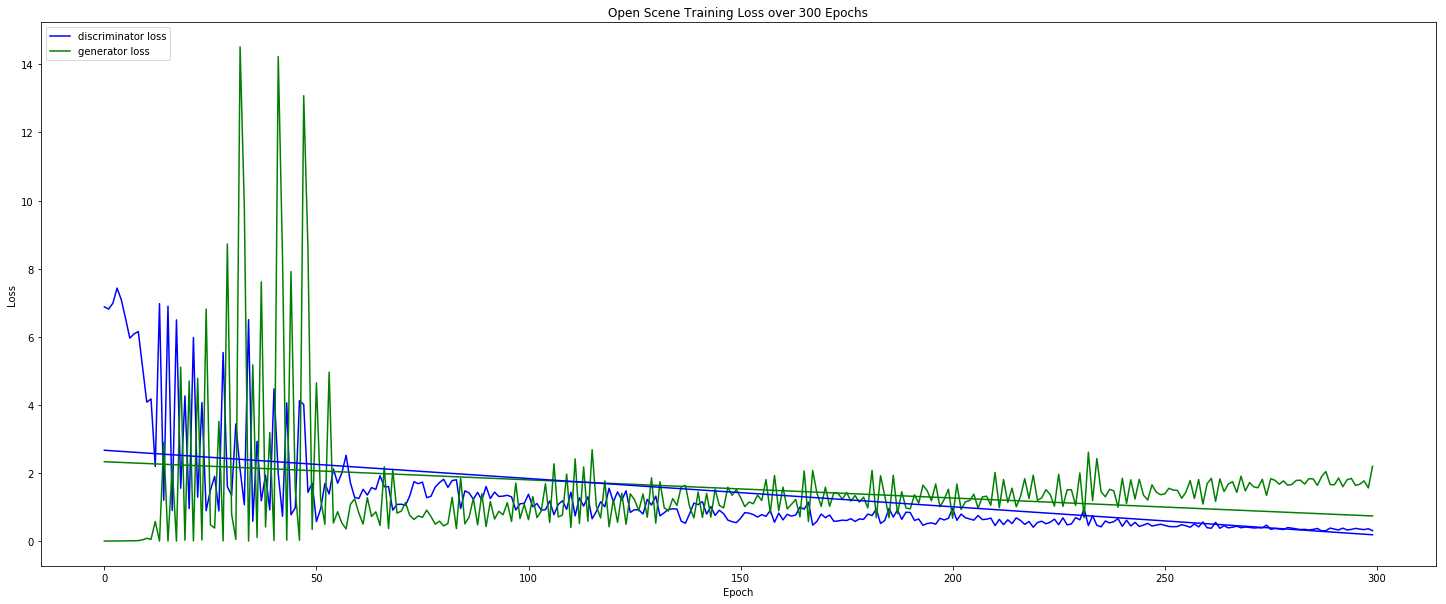

In [110]:
plt.figure(num=1, figsize=(25,10))
plt.plot(all_epoch, cropped_d_loss, c='blue')
plt.plot(all_epoch, cropped_g_loss, c='green')
plt.legend(['discriminator loss', 'generator loss'], loc='upper left')
bf_cropped_g = np.poly1d(np.polyfit(all_epoch, cropped_g_loss, 1))(all_epoch)
bf_cropped_d = np.poly1d(np.polyfit(all_epoch, cropped_d_loss, 1))(all_epoch)
plt.plot(all_epoch, bf_open_g, c="green")
plt.plot(all_epoch, bf_open_d, c="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Open Scene Training Loss over 300 Epochs")
plt.show()

## Main Investigation: Open Scene Monet
While I was happily surprised that it seemed that the model picked up Monet's hurried, impressionist style, these images didn't seem quite right. I wondered if it was an artifact of my incredibly diverse, tiny training dataset. Because I couldn't produce more Monets from thin air, I instead decided to create a second Monet dataset of only seascapes and landscapes. I noticed that incredibly different color palettes and subject matter was present in open scenes (landscapes and seascapes) versus closed scenes (people and flowers), and I hoped that by narrowing down the diversity in my dataset (although it resulted in a smaller set), would provide enough reglarity in the images to produce better end results. Data in this new set was comprised of the landscapes and seascapes from the previous data set, with additional landscapes and seascapes found via wikiart and Google Images.

![Landscape 1](./data/monet_open/cap-martin-2.jpg)
![Landscape 2](./data/monet_open/land2.jpeg)

![Seascape 1](./data/monet_open/boats-at-rest-at-petit-gennevilliers.jpg)
![Seascape 2](./data/monet_open/fishing-boats-calm-sea.jpg)


A model was trained using this open scene dataset using the bash command below. **Please note, if you run this, you will over-write existing models. Only run if you're _absolutely sure!_**

In [ ]:
%%bash
python3 main.py --dataset=monet_open --input_height=250 --input_width=250 --train_size=73 --epoch=300 --crop --train

### Open Scene Monet Results
I am proud to say that changing my training data allowed my model to pick up on some key features of Monet's paintings a little better. In the following images, you'll see that the model was able to capture some consistent color palettes of the seascapes and landscapes, and was additionally able to place a bright spot in the upper half of the image, which could correspond to the glint of sun on the water in seascapes, or the sun in landscapes.

**Epoch 2**
![Open Epoch 2](./samples/monet_open/train_02_0000.png)
**Epoch 53**
![Open Epoch 53](./samples/monet_open/train_53_0000.png)
**Epoch 131**
![Open Epoch 131](./samples/monet_open/train_131_0000.png)
**Epoch 200**
![Open Epoch 200](./samples/monet_open/train_200_0000.png)
**Epoch 254**
![Open Epoch 254](./samples/monet_open/train_254_0000.png)
**Epoch 299**
![Open Epoch 299](./samples/monet_open/train_299_0000.png)

In [65]:
with open("Open_loss.txt", "rt") as f:
    epoch = 0
    open_d_loss = []
    open_g_loss = []
    all_epoch = []
    for line in f:
        if line.startswith("[Sample]"):
            continue
        line = line.split(',')
        d_loss_txt = line[1]
        d_loss = d_loss_txt.split()[1]
        open_d_loss.append(float(d_loss))
        g_loss_txt = line[2]
        g_loss = g_loss_txt.split()[1]
        open_g_loss.append(float(g_loss))
        all_epoch.append(epoch)
        epoch += 1

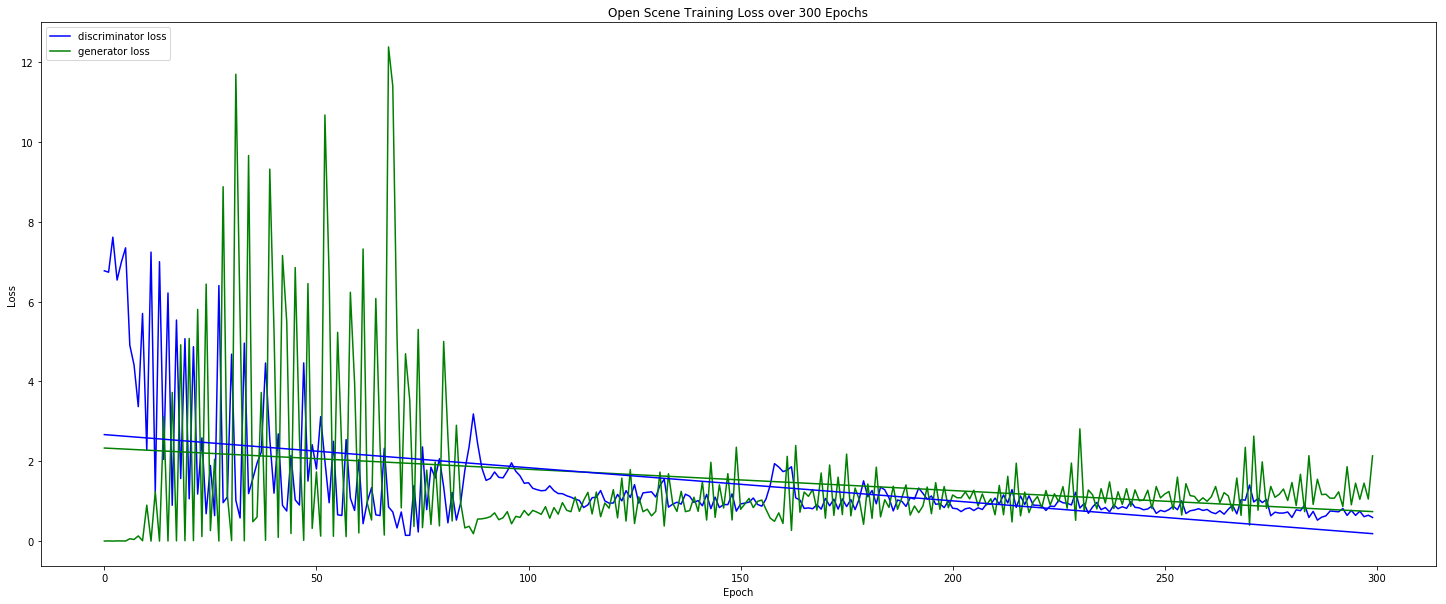

In [68]:
plt.figure(num=1, figsize=(25,10))
plt.plot(all_epoch, open_d_loss, c='blue')
plt.plot(all_epoch, open_g_loss, c='green')
plt.legend(['discriminator loss', 'generator loss'], loc='upper left')
bf_open_g = np.poly1d(np.polyfit(all_epoch, open_g_loss, 1))(all_epoch)
bf_open_d = np.poly1d(np.polyfit(all_epoch, open_d_loss, 1))(all_epoch)
plt.plot(all_epoch, bf_open_g, c="green")
plt.plot(all_epoch, bf_open_d, c="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Open Scene Training Loss over 300 Epochs")
plt.show()

In [ ]:
from IPython.display import HTML
HTML('<img src="./monet_open_training.gif">')

### Other Monet Conditions To Train With:
* Scrambled pixels
* Black and white

Training with these different perturbations of monet's works will help us know what is important for making something "Monet-ish". Is it the spatial integrity? If it were, scrambled pixels should show significantly worse generated images than normal images. Is it the color palette that Monet used? If it were that, converting images to black and white for training should yield significantly worse generated images than the normal images.

** Work in progress **

## Investigation: Black and White Monet Paintings

Next, I wanted to see what aspects of Monet's paintings were important for knowing whether something is "Monet-ish". Now I'll train on black and white images of Monet's paintings, using the same dataset as the set above. 

In [ ]:
%matplotlib inline

if not os.getcwd().endswith("data/monet_open_bw"):
    os.chdir("./data/monet_open_bw")

for im_name in os.listdir('.'):
    image = Image.open(im_name).convert("L")
    arr = np.asarray(image)
    im.imsave(im_name, arr, cmap=plt.cm.gray)

os.chdir("../..")

Training data examples:

![Black and White 1](./data/monet_open_bw/fisherman-s-cottage-at-varengeville.jpg)
![Black and White 2](./data/monet_open_bw/impression-sunrise.jpg)


In [ ]:
%%bash
python3 main.py --dataset=monet_open --input_height=250 --input_width=250 --train_size=73 --epoch=300 --crop --train

### Black and White Monet Results

**Epoch 1**
![BW Epoch 1](./samples/monet_open_bw/train_01_0000.png)
**Epoch 52**
![BW Epoch 52](./samples/monet_open_bw/train_52_0000.png)
**Epoch 130**
![BW Epoch 131](./samples/monet_open_bw/train_130_0000.png)
**Epoch 199**
![BW Epoch 199](./samples/monet_open_bw/train_199_0000.png)
**Epoch 253**
![BW Epoch 253](./samples/monet_open_bw/train_253_0000.png)
**Epoch 298**
![BW Epoch 298](./samples/monet_open_bw/train_298_0000.png)

In [61]:
with open("Bw_loss.txt", "rt") as f:
    epoch = 0
    bw_d_loss = []
    bw_g_loss = []
    all_epoch = []
    for line in f:
        if line.startswith("[Sample]"):
            continue
        line = line.split(',')
        d_loss_txt = line[1]
        d_loss = d_loss_txt.split()[1]
        bw_d_loss.append(float(d_loss))
        g_loss_txt = line[2]
        g_loss = g_loss_txt.split()[1]
        bw_g_loss.append(float(g_loss))
        all_epoch.append(epoch)
        epoch += 1

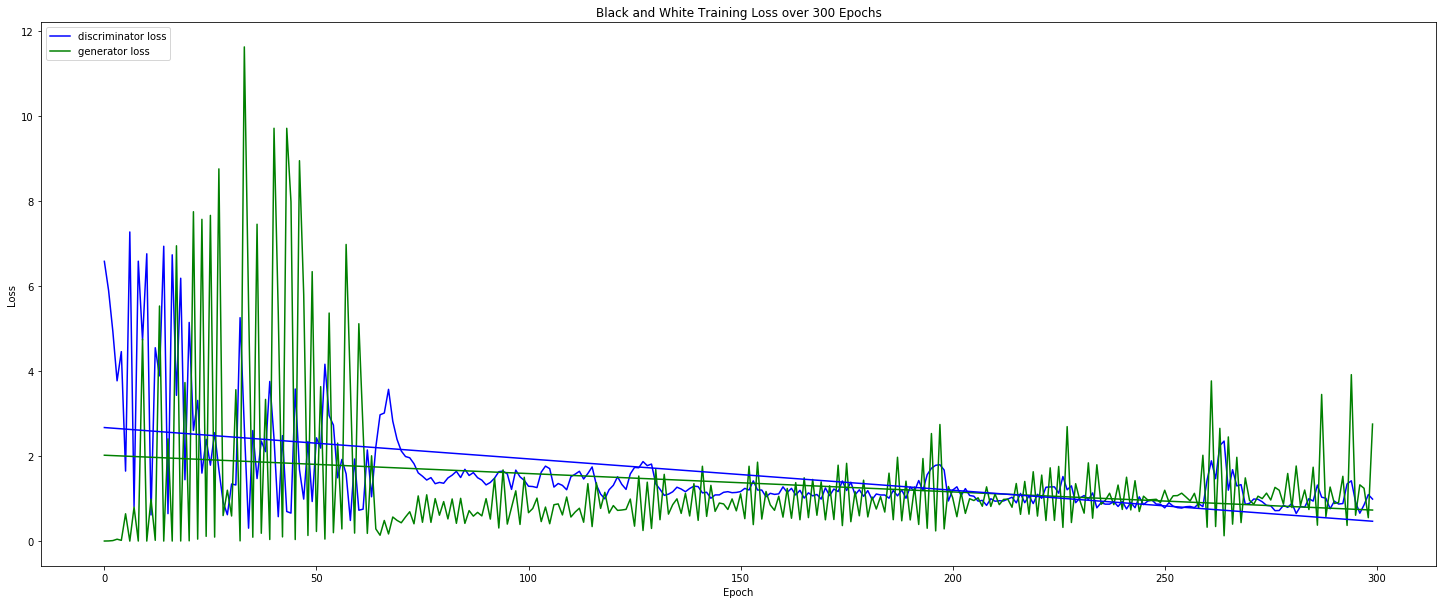

In [74]:
plt.figure(num=1, figsize=(25,10))
plt.plot(all_epoch, bw_d_loss, c='blue')
plt.plot(all_epoch, bw_g_loss, c='green')
bf_bw_g = np.poly1d(np.polyfit(all_epoch, bw_g_loss, 1))(all_epoch)
bf_bw_d = np.poly1d(np.polyfit(all_epoch, bw_d_loss, 1))(all_epoch)
plt.plot(all_epoch, bf_bw_g, c="green")
plt.plot(all_epoch, bf_bw_d, c="blue")
plt.legend(['discriminator loss', 'generator loss'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Black and White Training Loss over 300 Epochs")
plt.show()

### Investigation: Scrambled Monet Images
Now, we'll vary the spatial integrity of the monet images, but preserve color, to see how the network converges. First, we'll scramble the images using modifications to a script I found here: https://codegolf.stackexchange.com/questions/35005/rearrange-pixels-in-image-so-it-cant-be-recognized-and-then-get-it-back/35331
This scrambling is really interesting. It doesn't lead to a random scramble, but instead the scrambling depends on roatating different blocks of the image. Thus, there is still a structure to the image, but it's not the structure of _Monet_. This could help us figure out whether there's something special about how Monet himself structured his images.

In [2]:
def rot(A, n, x1, y1): #this is the function which rotates a given block
    temple = []
    for i in range(n):
        temple.append([])
        for j in range(n):
            temple[i].append(arr[x1+i, y1+j])
    for i in range(n):
        for j in range(n):
            arr[x1+i,y1+j] = temple[n-1-i][n-1-j]

In [5]:
import math

if not os.getcwd().endswith("data/monet_open_scramble"):
    os.chdir("./data/monet_open_scramble")

for im_name in os.listdir('.'):
    im = Image.open(im_name, "r")
    arr = im.load() #pixel data stored in this 2D array

    xres = 250
    yres = 250
    BLKSZ = 50 #blocksize
    for i in range(2, BLKSZ+1):
        for j in range(int(math.floor(float(xres)/float(i)))):
            for k in range(int(math.floor(float(yres)/float(i)))):
                rot(arr, i, j*i, k*i)
    for i in range(3, BLKSZ+1):
        for j in range(int(math.floor(float(xres)/float(BLKSZ+2-i)))):
            for k in range(int(math.floor(float(yres)/float(BLKSZ+2-i)))):
                rot(arr, BLKSZ+2-i, j*(BLKSZ+2-i), k*(BLKSZ+2-i))

    im.save(im_name)

Examples of scrambled output images, produced via the script above:

![Landscape 1](./data/monet_open_scramble/cap-martin-2.jpg)
![Landscape 2](./data/monet_open_scramble/land2.jpeg)

![Seascape 1](./data/monet_open_scramble/boats-at-rest-at-petit-gennevilliers.jpg)
![Seascape 2](./data/monet_open_scramble/fishing-boats-calm-sea.jpg)

### Scrambled Monet Results

**Epoch 1**
![Scrambled Epoch 1](./samples/monet_open_scramble/train_01_0000.png)
**Epoch 53**
![Scrambled Epoch 53](./samples/monet_open_scramble/train_53_0000.png)
**Epoch 131**
![Scrambled Epoch 131](./samples/monet_open_scramble/train_131_0000.png)
**Epoch 200**
![Scrambled Epoch 200](./samples/monet_open_scramble/train_200_0000.png)
**Epoch 254**
![Scrambled Epoch 254](./samples/monet_open_scramble/train_254_0000.png)
**Epoch 299**
![Scrambled Epoch 299](./samples/monet_open_scramble/train_299_0000.png)

In [54]:
with open("Scrambled_loss.txt", "rt") as f:
    epoch = 0
    scrambled_d_loss = []
    scrambled_g_loss = []
    all_epoch = []
    for line in f:
        if line.startswith("[Sample]"):
            continue
        line = line.split(',')
        d_loss_txt = line[1]
        d_loss = d_loss_txt.split()[1]
        scrambled_d_loss.append(float(d_loss))
        g_loss_txt = line[2]
        g_loss = g_loss_txt.split()[1]
        scrambled_g_loss.append(float(g_loss))
        all_epoch.append(epoch)
        epoch += 1

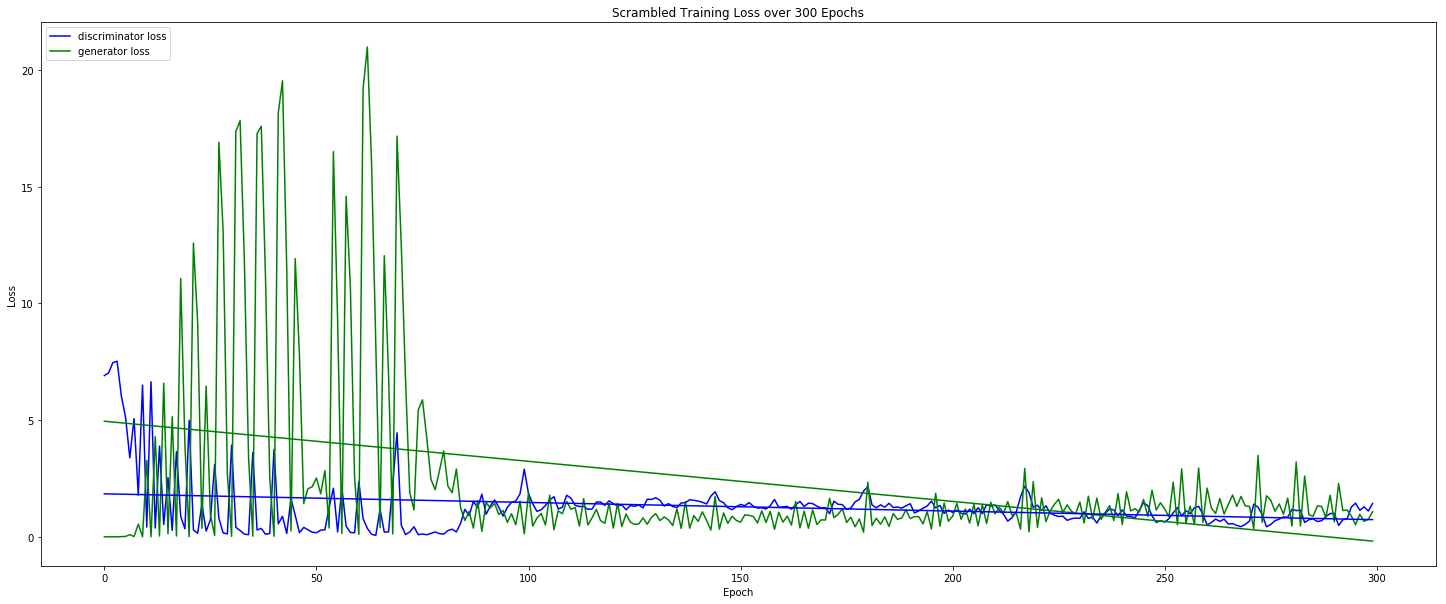

In [73]:
plt.figure(num=1, figsize=(25,10))
plt.plot(all_epoch, scrambled_d_loss, c='blue')
plt.plot(all_epoch, scrambled_g_loss, c='green')
plt.legend(['discriminator loss', 'generator loss'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Scrambled Training Loss over 300 Epochs")
bf_scram_g = np.poly1d(np.polyfit(all_epoch, scrambled_g_loss, 1))(all_epoch)
bf_scram_d = np.poly1d(np.polyfit(all_epoch, scrambled_d_loss, 1))(all_epoch)
plt.plot(all_epoch, bf_scram_g, c="green")
plt.plot(all_epoch, bf_scram_d, c="blue")
plt.show()

## General Discussion

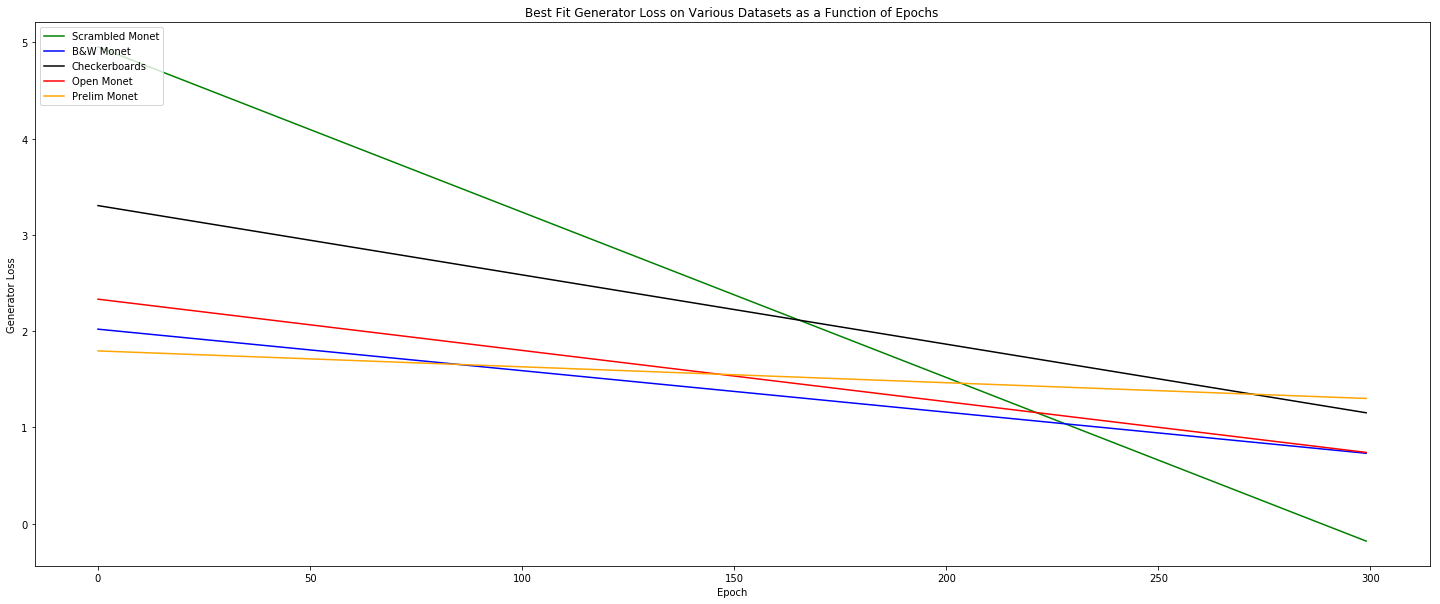

In [121]:
plt.figure(num=1, figsize=(25,10))
plt.plot(all_epoch, bf_scram_g, c="green")
plt.plot(all_epoch, bf_bw_g, c="blue")
plt.plot(all_epoch, bf_check_g, c="black")
plt.plot(all_epoch, bf_open_g, c="red")
plt.plot(all_epoch, bf_cropped_g, c="orange")
plt.xlabel("Epoch")
plt.ylabel("Generator Loss")
plt.title("Best Fit Generator Loss on Various Datasets as a Function of Epochs")
plt.legend(['Scrambled Monet', 'B&W Monet', 'Checkerboards', 'Open Monet', 'Prelim Monet'], loc='upper left')
plt.show()

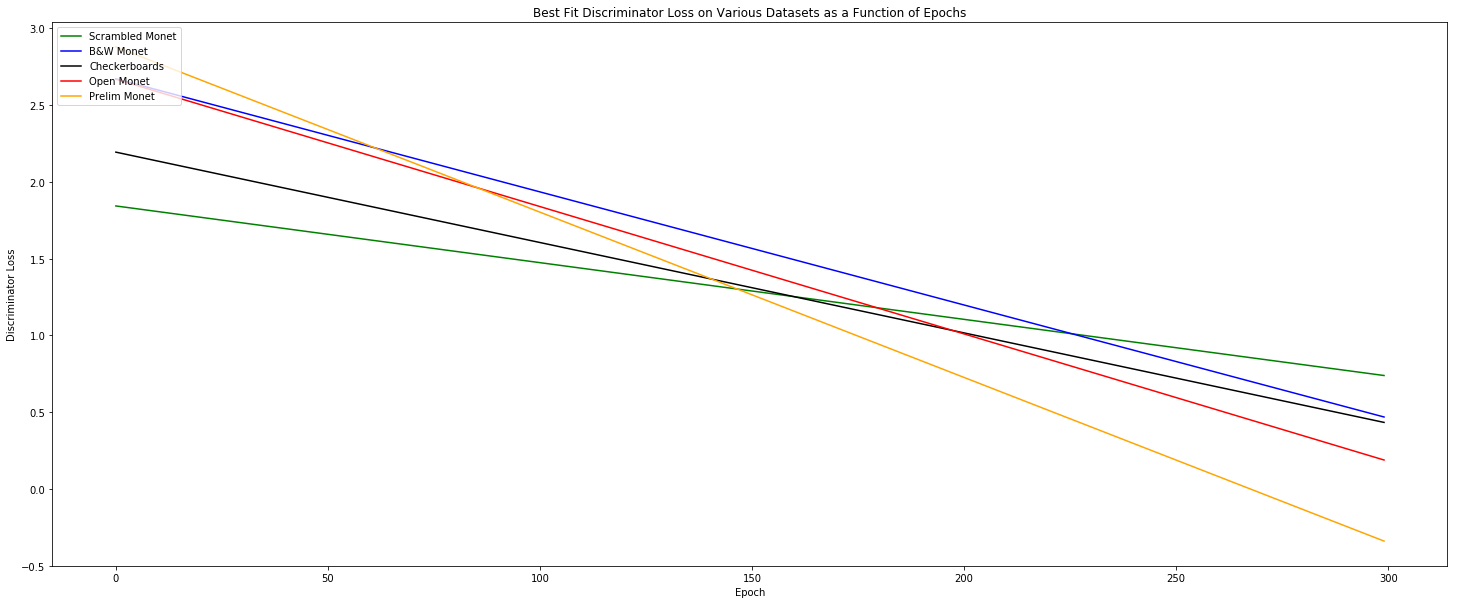

In [122]:
plt.figure(num=1, figsize=(25,10))
plt.plot(all_epoch, bf_scram_d, c="green")
plt.plot(all_epoch, bf_bw_d, c="blue")
plt.plot(all_epoch, bf_check_d, c="black")
plt.plot(all_epoch, bf_open_d, c="red")
plt.plot(all_epoch, bf_cropped_d, c="orange")
plt.xlabel("Epoch")
plt.ylabel("Discriminator Loss")
plt.title("Best Fit Discriminator Loss on Various Datasets as a Function of Epochs")
plt.legend(['Scrambled Monet', 'B&W Monet', 'Checkerboards', 'Open Monet', 'Prelim Monet'], loc='upper left')
plt.show()

Loss, in machine learning, specifies the amount of cost incurred on the network when the true value of the data is different from the predicted value of the data. Thinking about loss is tricky. Loss between different training sets cannot be directly compared against each other, since different training sets had different dimensions that the model was trying to train to. However, I think the slopes of these loss functions over time is interesting.

Looking at the generator network, I find that the datasets from which the best images were generated (by visual inspection) had the steepest slopes of change in loss over time. Meanwhile, the preliminary Monet dataset, for example, produced loss that had a constant loss over time. This constant loss could indicate that the network wasn't able to find any way to successfully "step down" the error gradient as it performed gradient descent. With more epochs or a greater training data set, perhaps we would have seen a sharp decrease in loss at some point.

The discriminator network loss is a little bit easier to interpret. The loss in this network corresponds to the discriminator network learning which images are generated and which images are true training images. Therefore, a low loss indicates that the discriminator was trained effectively, while a high loss indicates that the network is still error-prone. At 300 epochs, the lowest loss is shown for the open scene Monet and preliminary Monet image sets. While at first pass, one might think this is a good thing, this data combined with the fact that the generator loss is quite high indicates that the discriminator network is very good at discriminating generated images from training images -- because the generator network is doing a poor job at creating images that are easily confusable with the training images. 

The scrambled monet data set seems to perform the best. It has the highest discriminator loss at 300 epochs, with the lowest generator loss at 300 epochs. This means that the discriminator network is making errors in differentiating between training images and generated images, but the generator network is quite happy with the images it's creating. 

The checkerboards example is a great example of the network creating images that _seem_ like 


## Still to do: 
* quantification (gloss and dloss over training)
* Train binary image classifier that can say if a generated image is "monet" or "not monet" -- allows for quantification
* talk about how this could have been made better (ie: greater training data)

## Conclusion:
In my conclusion, I plan to:
* Explain how generative models can help us understand what the key features of artwork are
* Maybe, when we think of works by famous artists we are making some sort of generative model in our own head!
* Compare how the model did across different works, compare end results. Can I tell them apart?
* Future directions and suggestions for improvement

## References:
* https://blog.openai.com/generative-models/
* https://arxiv.org/pdf/1511.06434.pdf
* https://github.com/carpedm20/DCGAN-tensorflow
* https://arxiv.org/pdf/1601.06759.pdf
* https://www.wikiart.org/
* Pointed me to wikiart database: https://arxiv.org/pdf/1505.00855.pdf
* https://docs.floydhub.com/examples/dcgan/
* https://stackoverflow.com/questions/2169478/how-to-make-a-checkerboard-in-numpy
* https://codegolf.stackexchange.com/questions/35005/rearrange-pixels-in-image-so-it-cant-be-recognized-and-then-get-it-back/35331
* https://stackoverflow.com/questions/4805048/how-to-get-different-colored-lines-for-different-plots-in-a-single-figure
* https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
* https://www.coursera.org/learn/ml-regression/lecture/cGUQ3/what-do-we-mean-by-loss
* https://danieltakeshi.github.io/2017/03/05/understanding-generative-adversarial-networks/

** To be put into a common reference format **